<center><img src="https://keras.io/img/logo-small.png" alt="Keras logo" width="100"><br/>
This starter notebook is provided by the Keras team.</center>

# BirdCLEF 2024 with [KerasCV](https://github.com/keras-team/keras-cv) and [Keras](https://github.com/keras-team/keras)

> The objective of this competition is to identify under-studied Indian bird species by their calls.

<div align="center">
  <img src="https://i.ibb.co/47F4P9R/birdclef2024.png" alt="BirdCLEF 2024">
</div>

This notebook guides you through the process of training a Deep Learning model to recognize bird species by their songs (audio data). Specifically, this notebook uses the EfficientNetV2 backbone from KerasCV on the competition dataset. It also shows how to convert audio data to mel-spectrograms using Keras.

Since this competition requires inference to be run only on CPU, we need to prepare separate notebooks for training (to run on GPU) and inference (to run on CPU). You can find the [inference notebook here](https://www.kaggle.com/code/awsaf49/birdclef24-kerascv-starter-infer).

<u>Fun fact</u>: This notebook is backend-agnostic, supporting TensorFlow, PyTorch, and JAX. Utilizing KerasCV and Keras allows us to choose our preferred backend. Explore more details on [Keras](https://keras.io/keras_core/announcement/).

In this notebook, you will learn:

- Designing a data pipeline for audio data, including audio-to-spectrogram conversion.
- Creating an augmentation pipeline with KerasCV.
- Loading the data efficiently using [`tf.data`](https://www.tensorflow.org/guide/data).
- Creating the model using KerasCV presets.
- Training the model.

**Note**: For a more in-depth understanding of KerasCV, refer to the [KerasCV guides](https://keras.io/guides/keras_cv/).


# Import Libraries 📚

In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"  # "jax" or "tensorflow" or "torch" 

import keras_cv
import keras
import keras.backend as K
import tensorflow as tf
import tensorflow_io as tfio

import numpy as np 
import pandas as pd

from glob import glob
from tqdm import tqdm

import librosa
import IPython.display as ipd
import librosa.display as lid

import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import KFold

cmap = mpl.cm.get_cmap('coolwarm')

import joblib
import tensorflow_hub as hub
import warnings
from ast import literal_eval
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


train_csv_path = 'tmp/train_google_labeled.csv'
output_path = 'tmp/train_prepared.csv'

# Check TensorFlow GPU availability
# print("TensorFlow GPU available:", tf.config.list_physical_devices('GPU'))
# tf.device('/GPU:0')
# # Check GPU device details
# !nvidia-smi


/tmp/ipykernel_23/615351216.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


In [2]:
from IPython.display import FileLink
FileLink(r'/kaggle/working/best_model.weights.h5')

/kaggle/working/best_model.weights.h5

## Library Version

In [3]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasCV:", keras_cv.__version__)

TensorFlow: 2.16.1
Keras: 3.3.3
KerasCV: 0.9.0


# Configuration ⚙️

In [4]:
class CFG:
    seed = 42
    
    # Input image size and batch size
    img_size = [224, 224]
    batch_size = 96
    
    # Audio duration, sample rate, and length
    duration = 5 # second
    sample_rate = 32000
    audio_len = duration*sample_rate
    
    # STFT parameters
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000
    
    
    # Number of epochs, model name
    epochs =15
    preset = 'efficientnetv2_b2_imagenet'
    
    # Data augmentation parameters
    augment=True

    # Class Labels for BirdCLEF 24
    class_names = sorted(os.listdir('/kaggle/input/birdclef-2024/train_audio/'))
    
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
   
    name2label = {v:k for k,v in label2name.items()}


    # KFold
    n_splits = 5
    # print(num_classes)
    

# Reproducibility ♻️
Sets value for random seed to produce similar result in each run.

In [5]:
tf.keras.utils.set_random_seed(CFG.seed)

# Dataset Path 📁

In [6]:
BASE_PATH = '/kaggle/input/birdclef-2024'

def get_length(f):
    x, _ = librosa.load(f, sr=CFG.sample_rate)
    return x.shape[0]

# Meta Data 📖

In [7]:
df = pd.read_csv(f'{BASE_PATH}/train_metadata.csv')

df['filepath'] = BASE_PATH + '/train_audio/' + df.filename
df['target'] = df.primary_label.map(CFG.name2label)
df['filename'] = df.filepath.map(lambda x: x.split('/')[-1])
df['xc_id'] = df.filepath.map(lambda x: x.split('/')[-1].split('.')[0])



print(df.shape)
lengths = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(get_length)(f) for f in tqdm(df['filepath'], total=len(df['filename']))
)

df['lengths'] = lengths
df = df.drop_duplicates(subset=['primary_label', 'author', 'lengths'])

print(df.shape)
# Display rwos
df = df.iloc[np.random.permutation(len(df))].reset_index(drop=True)
# df=df[:10000]
df.head(5)
# print(df['primary_label'].nunique())

(24459, 15)


  0%|          | 0/24459 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
100%|██████████| 24459/24459 [07:50<00:00, 52.01it/s] 


(24252, 16)


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,filepath,target,xc_id,lengths
0,putbab1,[],['song'],22.4310,103.9970,Pellorneum ruficeps,Puff-throated Babbler,Albert Lastukhin,Creative Commons Attribution-NonCommercial-Sha...,2.0,https://www.xeno-canto.org/210541,XC210541.ogg,/kaggle/input/birdclef-2024/train_audio/putbab...,136,XC210541,800810
1,pursun3,[],[''],11.9632,75.5785,Leptocoma zeylonica,Purple-rumped Sunbird,JISHNU KIZHAKKILLAM,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://xeno-canto.org/795207,XC795207.ogg,/kaggle/input/birdclef-2024/train_audio/pursun...,133,XC795207,194485
2,labcro1,['commyn'],['call'],18.5344,73.7853,Corvus macrorhynchos,Large-billed Crow,Rajgopal Patil,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://www.xeno-canto.org/157274,XC157274.ogg,/kaggle/input/birdclef-2024/train_audio/labcro...,100,XC157274,361953
3,graher1,[],['nocturnal flight call'],43.9348,4.8056,Ardea cinerea,Gray Heron,Paul MENARD,Creative Commons Attribution-NonCommercial-Sha...,0.0,https://www.xeno-canto.org/545118,XC545118.ogg,/kaggle/input/birdclef-2024/train_audio/graher...,62,XC545118,284192
4,litegr,[],"['call', 'flight call']",49.3773,-1.7832,Egretta garzetta,Little Egret,Jack Berteau,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://www.xeno-canto.org/492967,XC492967.ogg,/kaggle/input/birdclef-2024/train_audio/litegr...,106,XC492967,1409358


In [8]:


# warnings.filterwarnings("ignore")
# from warnings import simplefilter
# simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# # train_csv_path = 'tmp/train_noduplicates.csv'
# # train_path = 'data/train_audio/'
# output_path = '/kaggle/working/train_google_labeled.csv'

# # =============================#
# # == Preparing Google model == #
# # =============================#

# # Load pre-trained Google model
# model = hub.load(
#     'https://www.kaggle.com/models/google/bird-vocalization-classifier/TensorFlow2/bird-vocalization-classifier/1'
# )

# # Load species labels from the model's asset files
# labels_path = hub.resolve(
#     'https://kaggle.com/models/google/bird-vocalization-classifier/frameworks/tensorFlow2/variations/bird-vocalization-classifier/versions/1'
# ) + "/assets/label.csv"

# labels = pd.read_csv(labels_path)
# google_species_to_label = {k: v for k, v in zip(labels.index, labels['ebird2021'])}
# google_species_to_label_reverse = {k: v for k, v in zip(labels['ebird2021'], labels.index)}
# species_google = set(list(google_species_to_label.values()))

# =============================#
# == Processing BirdCLEF 2024 == #
# =============================#


# df['n_chunks'] = df['lengths'] // 160_000

# species2024 = df['primary_label']
# species2024 = set(list(species2024))

# # Find new species not in Google model
# new_species = list(species2024 - species_google)

# Matching Google model labels with BirdCLEF 2024 labels
# train2024_google = df[~df['primary_label'].isin(new_species)]
# species_2024_x_google = train2024_google['primary_label'].unique()

# species_to_label_2024_x_google = {}
# label_to_index_2024_x_google_reset_index = {}
# for i, spec in enumerate(list(species_2024_x_google)):
#     species_to_label_2024_x_google[spec] = google_species_to_label_reverse[spec]
#     label_to_index_2024_x_google_reset_index[i] = spec

# actual_indices = np.array(list(species_to_label_2024_x_google.values()))

# ==========================#
# == Labeling Train Audio == #
# ==========================#

# google_probs = {}
# for i in tqdm(range(len(df))):
#     obj = df.iloc[i]
#     filename = obj['filename']
#     n_chunks = obj['n_chunks']
#     length = obj['lengths']
    
#     # Load and preprocess audio
#     x_full, sr = librosa.load(obj['filepath'], sr=CFG.sample_rate)
#     x_full = x_full.astype(np.float32)
#     step = sr * 5  # 5-second chunks
#     offset_probs = {}
    
#     # Handle short audios
#     if n_chunks == 0:
#         x_full = np.hstack([x_full for _ in range(int(5 / (x_full.shape[0] / sr)) + 1)])
#         n_chunks = 1
    
#     # Process audio chunks
#     for i in range(n_chunks):
#         x = x_full[step * i : step * (i + 1)]
#         logits = None
#         if obj['primary_label'] in new_species:
#             logits = np.full(len(actual_indices), -20.0)  # Dummy logits for new species
#         else:
#             # Perform inference
#             input_tensor = tf.convert_to_tensor(x[np.newaxis, :], dtype=tf.float32)
#             infer = model.signatures['serving_default']
#             logits = infer(inputs=input_tensor)['output_0'].numpy()[0][actual_indices]

#         offset_probs[i * 5] = list(logits)
    
#     google_probs[filename] = offset_probs

# # ==============================#
# # == Saving the Results == #
# # ==============================#

# # Flatten the predictions into lists
# filename_list = []
# offset_list = []
# logits_list = []

# for filename, offset_dict in google_probs.items():
#     for offset, logits in offset_dict.items():
#         filename_list.append(filename)
#         offset_list.append(offset)
#         logits_list.append(logits)

# # Convert predictions to DataFrame
# logits_array = np.array(logits_list)
# metainfo_df = pd.DataFrame({'filename': filename_list, 'offset_seconds': offset_list})
# logit_df = pd.DataFrame(logits_array, columns=list(label_to_index_2024_x_google_reset_index.values()))
# df_temp = pd.concat([metainfo_df, logit_df], axis=1)
# df_google = pd.merge(df_temp,df, on=['filename'])

# # Add new species with dummy logits
# for spec in new_species:
#     df_google[spec] = -20.0
#     df_google.loc[df_google['primary_label'] == spec, spec] = 3.0

# # # Save the labeled dataset
# # df.to_csv(output_path, index=False)
# df_google.head()


In [9]:


# data = df_google

# data['secondary_labels'] = data['secondary_labels'].apply(literal_eval)
# LABELS = sorted(data['primary_label'].unique())

# # Find 'good' chunks (predicted label == ground truth label)
# data['predict'] = data[LABELS].idxmax(axis=1)
# wrong_idxs = data[data['predict'] != data['primary_label']].index
# right_idxs = data[data['predict'] == data['primary_label']].index
# sec_idxs = list()
# for idx in wrong_idxs:
#     row = data.iloc[idx]
#     if row.predict in row.secondary_labels:
#         sec_idxs.append(idx)
#         data.loc[idx, 'primary_label'] = row.predict
#         data.at[idx, 'secondary_labels'] = list()
# right_idxs = right_idxs.tolist() + sec_idxs
# all_wrong_filenames = (set(data.loc[wrong_idxs].filename.unique()) - set(data.loc[right_idxs].filename.unique()))
# data['good'] = 0
# data.loc[right_idxs, 'good'] = 1
# data.loc[data.filename.isin(all_wrong_filenames), 'good'] = 1

# # Apply softmax to logits
# data[LABELS] = tf.nn.softmax(tf.convert_to_tensor(data[LABELS].values, dtype=tf.float32), axis=-1).numpy()

# # Prepare pseudo labels
# pseudo_labels = data[LABELS].values
# le = LabelEncoder()
# data['label'] = le.fit_transform(data['primary_label'].values)
# ohe = OneHotEncoder(categories=[np.array(range(len(LABELS)))], sparse_output=False)
# true_labels = ohe.fit_transform(data['label'].values.reshape(-1, 1))
# data[LABELS] = true_labels

# # Add secondary labels
# idxseclab = data[data.secondary_labels.apply(lambda s: len(s) > 0)].index
# for idx in idxseclab:
#     sec_labs = data.loc[idx, 'secondary_labels']
#     sec_labs = list(set(sec_labs) & set(LABELS))
#     if len(sec_labs) > 0:
#         prime_lab = data.loc[idx, 'primary_label']
#         data.loc[idx, prime_lab] = 0.5
#         data.loc[idx, sec_labs] = 0.5 / len(sec_labs)
# true_labels = data[LABELS].values
# alpha = 0.95
# labels = alpha * true_labels + (1 - alpha) * pseudo_labels
# data[LABELS] = labels

# data.to_csv()
# # Save processed data
# data.head()
# data.to_csv("/kaggle/working/data.csv", index=False)




In [10]:
# print(data[LABELS])
# df= pd.read_csv("/kaggle/input/changed-data/data.csv");
# LABELS = sorted(df['primary_label'].unique())
# print(LABELS)
# # print(df['good'].unique())
# df['npy_data'] = list(df[['offset_seconds'] + LABELS].values)
# print(df['npy_data'])
# df.drop(columns=LABELS, inplace=True)
# df = df[df['rating'] >= 1.5]
# # print(df['good'].unique())
# df


# EDA 🎨

## Utility

In [11]:
def load_audio(filepath):
    audio, sr = librosa.load(filepath)
    return audio, sr

def get_spectrogram(audio):
    spec = librosa.feature.melspectrogram(y=audio, 
                                   sr=CFG.sample_rate, 
                                   n_mels=256,
                                   n_fft=2048,
                                   hop_length=512,
                                   fmax=CFG.fmax,
                                   fmin=CFG.fmin,
                                   )
    spec = librosa.power_to_db(spec, ref=1.0)
    min_ = spec.min()
    max_ = spec.max()
    if max_ != min_:
        spec = (spec - min_)/(max_ - min_)
    return spec

def display_audio(row):
    # Caption for viz
    caption = f'Id: {row.filename} | Name: {row.common_name} | Sci.Name: {row.scientific_name} | Rating: {row.rating}'
    # Read audio file
    audio, sr = load_audio(row.filepath)
    # Keep fixed length audio
    audio = audio[:CFG.audio_len]
    # Spectrogram from audio
    spec = get_spectrogram(audio)
    # Display audio
    print("# Audio:")
    display(ipd.Audio(audio, rate=CFG.sample_rate))
    print('# Visualization:')
    fig, ax = plt.subplots(2, 1, figsize=(12, 2*3), sharex=True, tight_layout=True)
    fig.suptitle(caption)
    # Waveplot
    lid.waveshow(audio,
                 sr=CFG.sample_rate,
                 ax=ax[0],
                 color= cmap(0.1))
    # Specplot
    lid.specshow(spec, 
                 sr = CFG.sample_rate, 
                 hop_length=512,
                 n_fft=2048,
                 fmin=CFG.fmin,
                 fmax=CFG.fmax,
                 x_axis = 'time', 
                 y_axis = 'mel',
                 cmap = 'coolwarm',
                 ax=ax[1])
    ax[0].set_xlabel('');
    fig.show()

## Sample 1

# Audio:


# Visualization:
(432577,)
22050


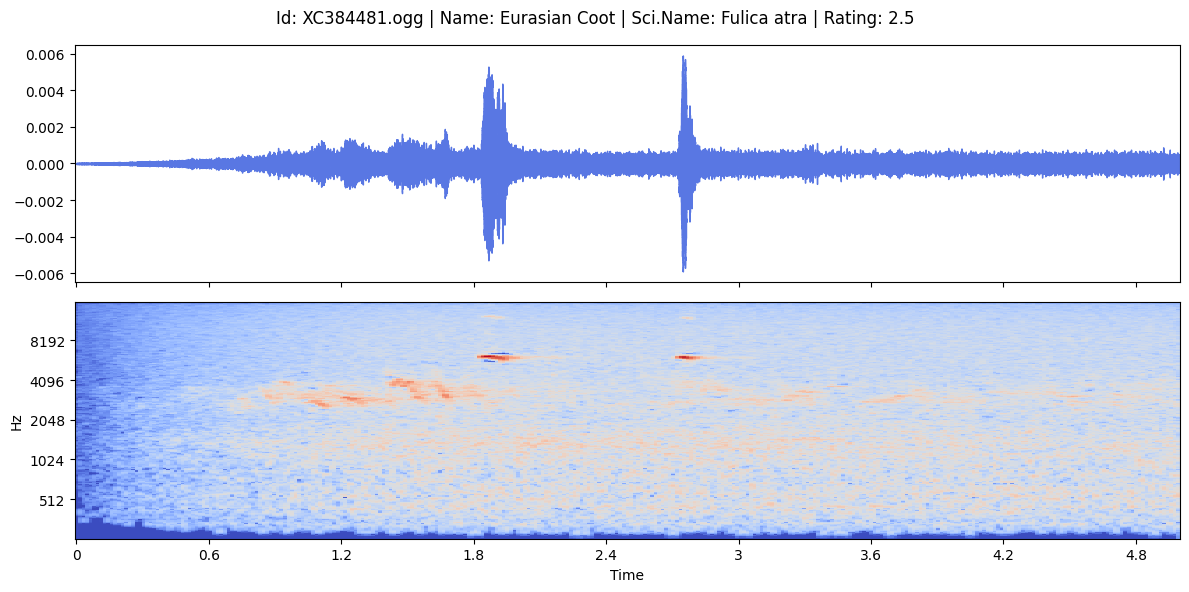

In [12]:
row = df.iloc[35]

# # Display audio
display_audio(row)
audio, sr = load_audio(row.filepath)
print(audio.shape)
print(sr)


## Sample 2

# Audio:


# Visualization:


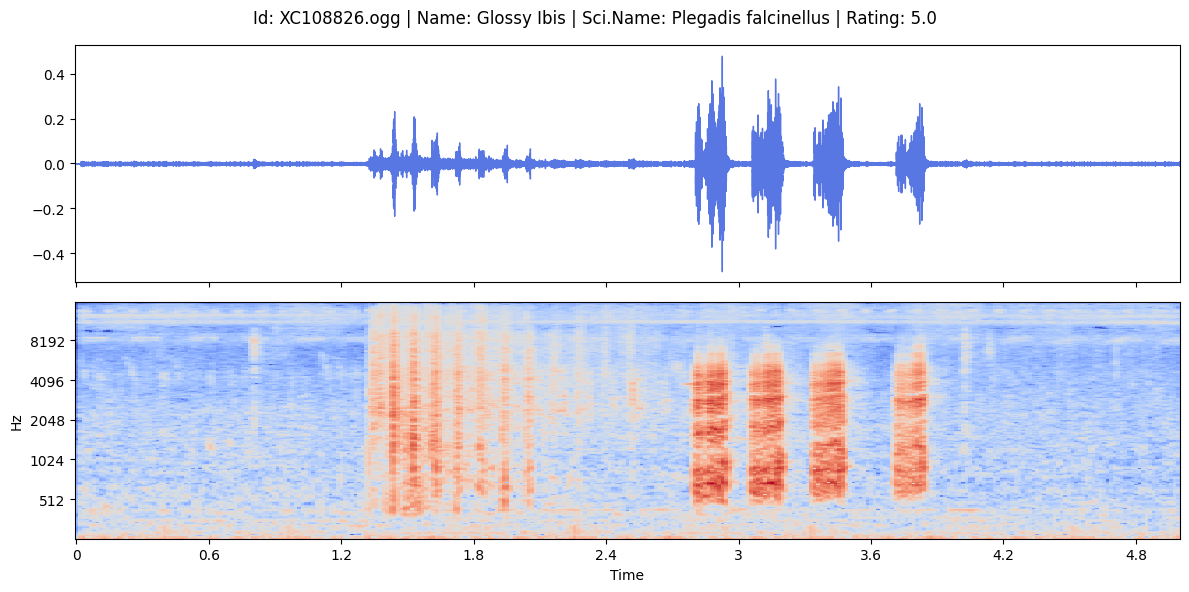

In [13]:
row = df.iloc[16]

# Display audio
display_audio(row)

## Sample 3

# Audio:


# Visualization:


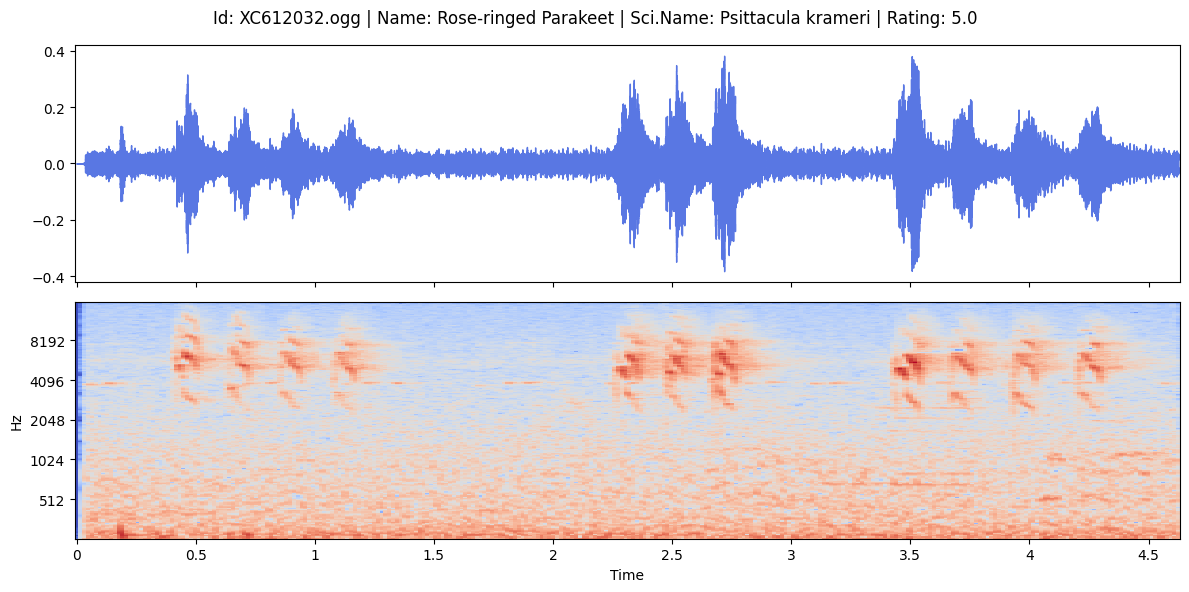

In [14]:
row = df.iloc[50]

# Display audio
display_audio(row)

# Data Split 🔪
Following code will split the data into folds using target stratification.
> **Note:** Some classess have too few samples thus not each fold contains all the classes. 

In [15]:
# # Import required packages
# from sklearn.model_selection import train_test_split

# train_df, valid_df = train_test_split(df, test_size=0.2)

# print(f"Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

# Data Loader 🍚

## Decoders

The following code will decode the raw audio from `.ogg` file and also decode the spectrogram from the `audio` file. Additionally, we will apply Z-Score standardization and Min-Max normalization to ensure consistent inputs to the model.


In [16]:


# Decodes Audio
def build_decoder(with_labels=True, dim=1024):
    def get_audio(filepath):
        file_bytes = tf.io.read_file(filepath)
        audio = tfio.audio.decode_vorbis(file_bytes)  # decode .ogg file
        audio = tf.cast(audio, tf.float32)
        if tf.shape(audio)[1] > 1:  # stereo -> mono
            audio = audio[..., 0:1]
        audio = tf.squeeze(audio, axis=-1)
        # print("sad")
        # print(audio[0])
        return audio

    def crop_or_pad(audio, target_len, pad_mode="constant"):
        audio_len = tf.shape(audio)[0]
        diff_len = abs(
            target_len - audio_len
        )  # find difference between target and audio length
        if audio_len < target_len:  # do padding if audio length is shorter
            pad1 = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
            pad2 = diff_len - pad1
            audio = tf.pad(audio, paddings=[[pad1, pad2]], mode=pad_mode)
        elif audio_len > target_len:  # do cropping if audio length is larger
            idx = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
            audio = audio[idx : (idx + target_len)]
        return tf.reshape(audio, [target_len])

    
    def apply_preproc(spec):
        # Standardize
        mean = tf.math.reduce_mean(spec)
        std = tf.math.reduce_std(spec)
        spec = tf.where(tf.math.equal(std, 0), spec - mean, (spec - mean) / std)

        # Normalize using Min-Max
        min_val = tf.math.reduce_min(spec)
        max_val = tf.math.reduce_max(spec)
        spec = tf.where(
            tf.math.equal(max_val - min_val, 0),
            spec - min_val,
            (spec - min_val) / (max_val - min_val),
        )
        return spec

    def get_target(target):
        target = tf.reshape(target, [1])
        target = tf.cast(tf.one_hot(target, CFG.num_classes), tf.float32)
        target = tf.reshape(target, [CFG.num_classes])
        return target

    def decode(path):
        # Load audio file
        audio = get_audio(path)
        # Crop or pad audio to keep a fixed length
        audio = crop_or_pad(audio, dim)
        # Audio to Spectrogram
        spec = keras.layers.MelSpectrogram(
            num_mel_bins=CFG.img_size[0],
            fft_length=CFG.nfft,
            sequence_stride=CFG.hop_length,
            sampling_rate=CFG.sample_rate,
            power_to_db=True,
        )(audio)
        # with tf.compat.v1.Session() as sess:
        #     print(sess.run(spec))
        # Apply normalization and standardization
        spec = apply_preproc(spec)
        # Spectrogram to 3 channel image (for imagenet)
        spec = tf.tile(spec[..., None], [1, 1, 3])
        spec = tf.reshape(spec, [*CFG.img_size, 3])
        return spec

    def decode_with_labels(path, label):
        label = get_target(label)
        return decode(path), label

    return decode_with_labels if with_labels else decode


## Augmenters
Following code will apply augmentations to spectrogram data. In this notebook, we will use MixUp, CutOut (TimeMasking and FreqMasking) from KerasCV.

> Note that, these augmentations will be applied to batch of spectrograms rather than single spectrograms.

In [17]:
def build_augmenter():
    augmenters = [
        keras_cv.layers.MixUp(alpha=0.4),
        keras_cv.layers.RandomCutout(height_factor=(1.0, 1.0),
                                     width_factor=(0.06, 0.12)), # time-masking
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.1),
                                     width_factor=(1.0, 1.0)), # freq-masking
    ]
    
    def augment(img, label):
        data = {"images":img, "labels":label}
        for augmenter in augmenters:
            if tf.random.uniform([]) < 0.35:
                data = augmenter(data, training=True)
                print("augmentation done")
        return data["images"], data["labels"]
    
    return augment

## Data Pipeline
Following code builds the complete pipeline of the data flow. It uses `tf.data.Dataset` for data processing. Here are some cool features of `tf.data`,
* We can build complex input pipelines from simple, reusable pieces using`tf.data` API . For example, the pipeline for an audio model might aggregate data from files in a distributed file system, apply random transformation/augmentation to each audio/spectrogram, and merge randomly selected data into a batch for training.
* Moreover `tf.data` API provides a `tf.data.Dataset` feature that represents a sequence of components where each component comprises one or more pieces. For instance, in an audio pipeline, a component might be a single training example, with a pair of tensor pieces representing the audio and its label.

Check out this [doc](https://www.tensorflow.org/guide/data) if you want to learn more about `tf.data`.

In [18]:
def build_dataset(paths, labels=None, batch_size=32, 
                  decode_fn=None, augment_fn=None, cache=True,
                  augment=False, shuffle=2048):

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None, dim=CFG.audio_len)

    if augment_fn is None:
        augment_fn = build_augmenter()
        
    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths,) if labels is None else (paths, labels)
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache() if cache else ds
    if shuffle:
        opt = tf.data.Options()
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

## Build Train and Valid Dataloaders

In [19]:
# Train
# train_paths = train_df.filepath.values
# train_labels = train_df.target.values
# train_ds = build_dataset(train_paths, train_labels, batch_size=CFG.batch_size,
#                          shuffle=True, augment=CFG.augment)

# print(train_df)
# # Valid
# valid_paths = valid_df.filepath.values
# valid_labels = valid_df.target.values
# valid_ds = build_dataset(valid_paths, valid_labels, batch_size=CFG.batch_size,
#                          shuffle=False, augment=False)

# Visualization 🔭
To ensure our pipeline is generating **spectrogram** and its associate **label** correctly, we'll check some samples from a batch.

In [20]:
def plot_batch(batch, row=3, col=3, label2name=None,):
    """Plot one batch data"""
    if isinstance(batch, tuple) or isinstance(batch, list):
        specs, tars = batch
    else:
        specs = batch
        tars = None
    plt.figure(figsize=(col*5, row*3))
    for idx in range(row*col):
        ax = plt.subplot(row, col, idx+1)
        lid.specshow(np.array(specs[idx, ..., 0]), 
                     n_fft=CFG.nfft, 
                     hop_length=CFG.hop_length, 
                     sr=CFG.sample_rate,
                     x_axis='time',
                     y_axis='mel',
                     cmap='coolwarm')
        if tars is not None:
            label = tars[idx].numpy().argmax()
            name = label2name[label]
            plt.title(name)
    plt.tight_layout()
    plt.show()

In [21]:
# sample_ds = train_ds.take(100)
# batch = next(iter(sample_ds))
# plot_batch(batch, label2name=CFG.label2name)

# 🤖 Modeling

Building a model for an audio recognition task with spectrograms as input is quite straightforward, as it is very similar to image classification. This is because the shape of spectrogram data is very similar to image data. In this notebook, to perform the audio recognition task, we will utilize the `EfficientNetV2` ImageNet-pretrained model as the backbone. Even though this backbone is pretrained with ImageNet data instead of spectrogram data, we can leverage transfer learning to adapt it to our spectrogram-based task.

> Note that we can train our model on any duration audio file (here we are using `10 seconds`), but we will always infer on `5-second` audio files (as per competition rules). To facilitate this, we have set the model input shape to `(None, None, 3)`, which will allow us to have variable-length input during training and inference.


In case you are wondering, **Why not train and infer on both `5-second`?** In the train data, we have long audio files, but we are not sure which part of the audio contains the labeled bird's song. In other words, this is weakly labeled. To ensure the provided label is accurately suited to the audio, we are using a larger audio size than `5 seconds`. You are welcome to try out different audio lengths for training.


In [22]:
# ###using regnet
# # Create an input layer for the model
# inp = keras.layers.Input(shape=(None, None, 3))

# # Pretrained RegNetY_008 backbone
# backbone = keras_cv.models.RegNetYBackbone.from_preset(
#     "regnety_008_imagenet",  # Preset name for RegNetY_008
# )

# # Define the output classifier layer
# out = keras_cv.models.ImageClassifier(
#     backbone=backbone,
#     num_classes=CFG.num_classes,
#     name="classifier"
# )(inp)

# # Build model
# model = keras.models.Model(inputs=inp, outputs=out)

# # Compile model with optimizer, loss, and metrics
# model.compile(optimizer="adamW",
#               loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),
#               metrics=[keras.metrics.AUC(name='auc')],
#              )

# model.summary()

In [23]:


# Create an input layer for the model
inp = keras.layers.Input(shape=(None, None, 3))

# Pretrained ResNet152V2 backbone (without top layers)
backbone = keras.applications.ResNet152V2(
    include_top=False,            # Exclude fully connected top layers
    weights="imagenet",           # Pretrained on ImageNet
    input_tensor=inp,             # Pass the input tensor
    pooling="avg"                 # Global average pooling layer
)

# Add a custom dense layer for classification
out = keras.layers.Dense(
    units=CFG.num_classes,        # Number of output classes
    activation=None,              # No activation here; add softmax explicitly later
    name="classifier"
)(backbone.output)

# Explicitly append a Softmax Activation Layer
output_with_softmax = keras.layers.Activation(
    "softmax", name="softmax_output"
)(out)

# Define the model
model = keras.models.Model(inputs=inp, outputs=output_with_softmax)

# Compile the model
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=1e-4),  # Use AdamW optimizer
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),
    metrics=[keras.metrics.AUC(name='auc')]
)

# Model summary
model.summary()



234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, None,      │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, None,      │          0 │ conv2_block1_pre… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, None,      │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, None,      │          0 │ conv2_block1_0_c

 Total params: 58,704,566 (223.94 MB)

 Trainable params: 58,560,822 (223.39 MB)

 Non-trainable params: 143,744 (561.50 KB)

# LR Schedule ⚓
* Learning Rate scheduler for transfer learning. 
* The learning rate starts from `lr_start`, then decreases to a`lr_min` using different methods namely,
    * **step**: Reduce lr step wise like stair.
    * **cos**: Follow Cosine graph to reduce lr.
    * **exp**: Reduce lr exponentially.

In [24]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=15, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 8e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75


    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

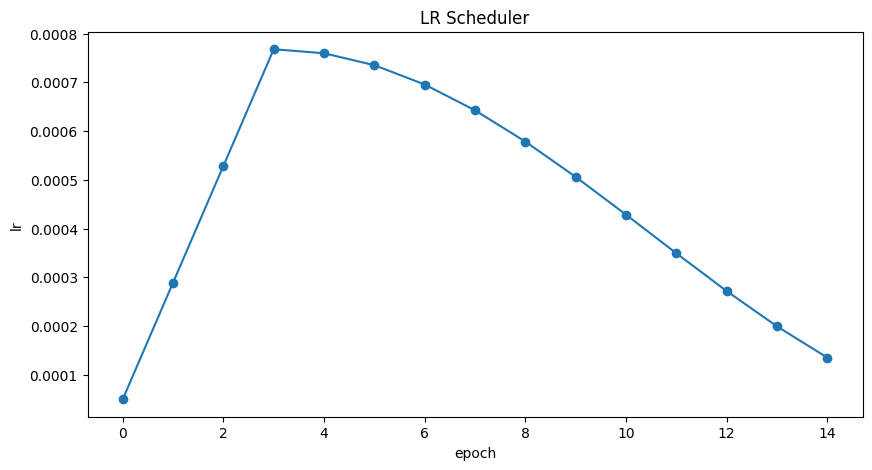

In [25]:
lr_cb = get_lr_callback(CFG.batch_size, plot=True)

# Model Checkpoint 💾

In [26]:
ckpt_cb = keras.callbacks.ModelCheckpoint("best_model.weights.h5",
                                         monitor='val_auc',
                                         save_weights_only=True,
                                         )

# Training 🚄

In [27]:
kfold = KFold(n_splits=CFG.n_splits, shuffle=True, random_state=42)

# results = []
# Final_best_score=0
# for fold, (train_idx, val_idx) in enumerate(kfold.split(df)):
#     print(f"Fold {fold + 1}")
    
# Split data
train_idx, val_idx = list(kfold.split(df,df['primary_label']))[0]
train_df=df.iloc[train_idx]
valid_df=df.iloc[val_idx]

#     # Create a new model instance for each fold
#     # Train
train_paths = train_df.filepath.values
train_labels = train_df.target.values
train_ds = build_dataset(train_paths, train_labels, batch_size=CFG.batch_size,
                         shuffle=True, augment=CFG.augment)

# Valid
valid_paths = valid_df.filepath.values
valid_labels = valid_df.target.values
valid_ds = build_dataset(valid_paths, valid_labels, batch_size=CFG.batch_size,
                         shuffle=False, augment=False)

#  # # Train the model
#  # history = model.fit(
#  #     X_train, y_train,
#  #     validation_data=(X_val, y_val),
#  #     epochs=5,  # Adjust based on your needs
#  #     batch_size=32,
#  #     verbose=1
#  # )
history = model.fit(
train_ds, 
validation_data=valid_ds, 
epochs=CFG.epochs,
batch_size=CFG.batch_size,
callbacks=[lr_cb,ckpt_cb], 
verbose=1
)

# Evaluate on validation data
# scores = model.evaluate(X_val, y_val, verbose=0)

best_epoch = np.argmax(history.history["val_auc"])
best_score = history.history["val_auc"][best_epoch]
    # print(f"Fold {fold + 1} Accuracy: {best_score:.4f}")
    # results.append(best_score)
    # if best_score> Final_best_score :
    #     Final_best_score=best_score
    #     model.save_weights("best_model.weights.h5")

# Compute final results
# mean_accuracy = np.mean(results)
# std_accuracy = np.std(results)
# print(f"Final Mean Accuracy: {mean_accuracy:.4f}")
# print(f"Final Std Accuracy: {std_accuracy:.4f}")





augmentation done
augmentation done
augmentation done
Epoch 1/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 2483s 12s/step - auc: 0.6679 - loss: 4.8093 - val_auc: 0.8193 - val_loss: 3.8398 - learning_rate: 5.0000e-05
Epoch 2/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 228s 975ms/step - auc: 0.8278 - loss: 3.1922 - val_auc: 0.8892 - val_loss: 2.8041 - learning_rate: 2.8933e-04
Epoch 3/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 198s 976ms/step - auc: 0.8588 - loss: 2.4300 - val_auc: 0.8610 - val_loss: 3.2155 - learning_rate: 5.2867e-04
Epoch 4/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 199s 977ms/step - auc: 0.8717 - loss: 2.0641 - val_auc: 0.8616 - val_loss: 3.2840 - learning_rate: 7.6800e-04
Epoch 5/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 198s 977ms/step - auc: 0.8838 - loss: 1.7073 - val_auc: 0.8641 - val_loss: 3.3086 - learning_rate: 7.5972e-04
Epoch 6/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 198s 976ms/step - auc: 0.8915 - loss: 1.3735 - val_auc: 0.8833 - val_loss: 2.9278 - learning_rate: 7.3523e-04
Epoch 7/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 198s 97

## Result Summary

In [28]:
print(best_score)
# best_epoch = np.argmax(history.history["val_auc"])
# best_score = history.history["val_auc"][best_epoch]
# print('>>> Best AUC: ', best_score)
# print('>>> Best Epoch: ', best_epoch+1)

# model.load_weights("/kaggle/input/model-weights/best_model.weights.h5")
# from sklearn.model_selection import train_test_split

# train_df, valid_df = train_test_split(df, test_size=0.1)
# valid_paths = valid_df.filepath.values
# valid_labels = valid_df.target.values
# valid_ds = build_dataset(valid_paths, valid_labels, batch_size=CFG.batch_size,
#                          shuffle=False, augment=False)
# results = model.evaluate(valid_ds)
# print("Loss:", results[0])  # Assuming loss is the first metric
# print("Accuracy:", results[1])
# model.summary()

0.9476427435874939


# Reference ✍️
* [BirdCLEF23: Pretraining is All you Need [Train]](https://www.kaggle.com/code/awsaf49/birdclef23-pretraining-is-all-you-need-train) by @awsaf49
* [RANZCR: EfficientNet TPU Training](https://www.kaggle.com/code/xhlulu/ranzcr-efficientnet-tpu-training) by @xhlulu
* [Triple Stratified KFold with TFRecords](https://www.kaggle.com/code/cdeotte/triple-stratified-kfold-with-tfrecords) by @cdeotte